# Goal is to answer the question: can a machine detect a person's gender based on their tweet?

Steps:
1. Get twitter data
2. Clean
3. Analyze and visualize
4. Build model
5. Test model

In [127]:
# Import libraries
import numpy as np
import pandas as pd
import tweepy as tw
import seaborn as sns
import json
import pprint
from matplotlib import pyplot as plt

# Import libraries for WordCloud
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

import nltk
from nltk import PorterStemmer
import textblob
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [93]:
# Connect to twitter API
path_auth = '/Users/allenj/Documents/Keys/auth_twitter.json'
auth = json.loads(open(path_auth).read())
pp = pprint.PrettyPrinter(indent=4)

my_consumer_key = auth['my_consumer_key']
my_consumer_secret = auth['my_consumer_secret']
my_access_token = auth['your_access_token']
my_access_token_secret = auth['my_access_token_secret']

auth = tw.OAuthHandler(my_consumer_key, my_consumer_secret)
auth.set_access_token(my_access_token, my_access_token_secret)
api = tw.API(auth)

type(api)

tweepy.api.API

# 1. Get Twitter data

In [94]:
# Upload list of desired users
# Gender 0 = male, 1 = female
users = pd.read_csv('../Data/users.csv')
users

,user,name,gender,followers_millions,activity,country
0,BarackObama,Barack Obama,0,118,Former U.S. president,United States
1,justinbieber,Justin Bieber,0,111,Musician,Canada
2,katyperry,Katy Perry,1,108,Musician,United States
3,rihanna,Rihanna,1,96,Musician and businesswoman,Barbados
4,taylorswift13,Taylor Swift,1,86,Musician,United States
5,Cristiano,Cristiano Ronaldo,0,84,Footballer,Portugal
6,ladygaga,Lady Gaga,1,81,Musician and actress,United States
7,realDonaldTrump,Donald Trump,0,80,Current U.S. president,United States
8,TheEllenShow,Ellen DeGeneres,1,80,Comedian and television hostess,United States
9,ArianaGrande,Ariana Grande,1,74,Musician and actress,United States


In [116]:
# Get collection of tweets from these usernames and store it into a new dataframe
list = []

for index, row in users.iterrows():
    tweets = api.user_timeline(screen_name=row['user'], count=5, include_rts=False)
    users_text = [[tweet.user.screen_name, tweet.text, row['gender']] for tweet in tweets]
    tweet_text = pd.DataFrame(data=users_text, 
                        columns=["user", "text", "gender"])
    list.append(tweet_text)

# Merge the list    
tweets = pd.concat(list) 
tweets

,user,text,gender
0,BarackObama,My statement on the death of George Floyd: htt...,0
1,BarackObama,"If you believe in a more just, more generous, ...",0
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0
3,BarackObama,And here’s more on the approach Sweden has tak...,0
4,BarackObama,South Korea has focused on testing to guard ag...,0
...,...,...,...
0,NICKIMINAJ,🌮,1
1,NICKIMINAJ,I was in full quarantine/hiatus mode. No socia...,1
2,NICKIMINAJ,I guess I never answered this &amp; I c u guys...,1
3,NICKIMINAJ,😂 omg why we won https://t.co/7CvxNWnB36,1


In [102]:
# Count the number of datapoints per person
tweets.groupby(["user", "gender"]).size()

user             gender
Adele            1         5
AnushkaSharma    1         2
ArianaGrande     1         2
AvrilLavigne     1         4
BarackObama      0         5
BeingSalmanKhan  0         5
BillGates        0         5
BrunoMars        0         5
Cristiano        0         5
Drake            0         2
EmmaWatson       1         1
Harry_Styles     0         4
HillaryClinton   1         4
JLo              1         2
KevinHart4real   0         5
KimKardashian    1         4
KingJames        0         5
LilTunechi       0         5
Louis_Tomlinson  0         5
MariahCarey      1         3
MileyCyrus       1         2
NICKIMINAJ       1         5
NiallOfficial    0         3
Oprah            1         5
SrBachchan       0         5
TheEllenShow     1         4
akshaykumar      0         5
aliciakeys       1         3
britneyspears    1         5
ddlovato         1         2
elonmusk         0         5
iamsrk           0         5
imVkohli         0         5
jimmyfallon      0 

# Clean text

In [121]:
# Clean text by removing things
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

#Remove @ symbol, URL links, and "&amp;"
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['text'], "@[\w]*")
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "https?:\/\/.*[\r\n]*")
tweets['clean_text'] = np.vectorize(remove_pattern)(tweets['clean_text'], "&amp;")
tweets

,user,text,gender,clean_text
0,BarackObama,My statement on the death of George Floyd: htt...,0,My statement on the death of George Floyd:
1,BarackObama,"If you believe in a more just, more generous, ...",0,"If you believe in a more just, more generous, ..."
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,"On Memorial Day, we honor those who gave all f..."
3,BarackObama,And here’s more on the approach Sweden has tak...,0,And here’s more on the approach Sweden has tak...
4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea has focused on testing to guard ag...
...,...,...,...,...
0,NICKIMINAJ,🌮,1,🌮
1,NICKIMINAJ,I was in full quarantine/hiatus mode. No socia...,1,I was in full quarantine/hiatus mode. No socia...
2,NICKIMINAJ,I guess I never answered this &amp; I c u guys...,1,I guess I never answered this I c u guys chat...
3,NICKIMINAJ,😂 omg why we won https://t.co/7CvxNWnB36,1,😂 omg why we won


In [123]:
# Remove punctuation, numbers, and special characters
tweets['clean_text'] = tweets['clean_text'].str.replace("[^a-zA-Z#]", " ")
tweets.head(10)

,user,text,gender,clean_text
0,BarackObama,My statement on the death of George Floyd: htt...,0,My statement on the death of George Floyd
1,BarackObama,"If you believe in a more just, more generous, ...",0,If you believe in a more just more generous ...
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,On Memorial Day we honor those who gave all f...
3,BarackObama,And here’s more on the approach Sweden has tak...,0,And here s more on the approach Sweden has tak...
4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea has focused on testing to guard ag...
0,justinbieber,Thank you @angela_rye for the conversation,0,Thank you for the conversation
1,justinbieber,Live https://t.co/WUjCacT9ae,0,Live
2,justinbieber,In these streets https://t.co/Z1TtKLg2Q3,0,In these streets
3,justinbieber,Make your own #StuckwithU merch https://t.co/F...,0,Make your own #StuckwithU merch
0,katyperry,Some of u with sharp ears caught a glimpse of ...,1,Some of u with sharp ears caught a glimpse of ...


In [155]:
# Remove short words less than 2
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tweets.head(10)

,user,text,gender,clean_text
0,BarackObama,My statement on the death of George Floyd: htt...,0,statement death George Floyd
1,BarackObama,"If you believe in a more just, more generous, ...",0,believe more just more generous more democrati...
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,Memorial honor those gave That takes different...
3,BarackObama,And here’s more on the approach Sweden has tak...,0,here more approach Sweden taken which differs ...
4,BarackObama,South Korea has focused on testing to guard ag...,0,South Korea focused testing guard against outb...
0,justinbieber,Thank you @angela_rye for the conversation,0,Thank conversation
1,justinbieber,Live https://t.co/WUjCacT9ae,0,Live
2,justinbieber,In these streets https://t.co/Z1TtKLg2Q3,0,these streets
3,justinbieber,Make your own #StuckwithU merch https://t.co/F...,0,Make your #StuckwithU merch
0,katyperry,Some of u with sharp ears caught a glimpse of ...,1,Some with sharp ears caught glimpse this remix...


In [156]:
# Tokenization
tokenized_tweet = tweets['clean_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0                    [statement, death, George, Floyd]
1    [believe, more, just, more, generous, more, de...
2    [Memorial, honor, those, gave, That, takes, di...
3    [here, more, approach, Sweden, taken, which, d...
4    [South, Korea, focused, testing, guard, agains...
Name: clean_text, dtype: object

In [157]:
# # Stemming
# ps = PorterStemmer()
# tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])
# tokenized_tweet.head()

0                     [statement, death, georg, floyd]
1    [believ, more, just, more, gener, more, democr...
2    [memori, honor, those, gave, that, take, diffe...
3    [here, more, approach, sweden, taken, which, d...
4    [south, korea, focus, test, guard, against, ou...
Name: clean_text, dtype: object

In [153]:
# # Stich tokens back together
# for i in range(len(tokenized_tweet)):
#     tokenized_tweet[i] = ' '.join(str(tokenized_tweet[i]))
          
# tweets['clean_text'] = tokenized_tweet
# tweets.head(10) 

KeyError: 5

In [159]:
tweets['clean_text']

0                         statement death George Floyd
1    believe more just more generous more democrati...
2    Memorial honor those gave That takes different...
3    here more approach Sweden taken which differs ...
4    South Korea focused testing guard against outb...
                           ...                        
0                                                     
1    full quarantine hiatus mode social media clue ...
2    guess never answered this guys chatting text f...
3                                                     
4    love much Barbz just just never cease amaze ne...
Name: clean_text, Length: 192, dtype: object

# 2. Exploratory data analysis

Text(0.5, 1.0, 'Average tweet length by gender')

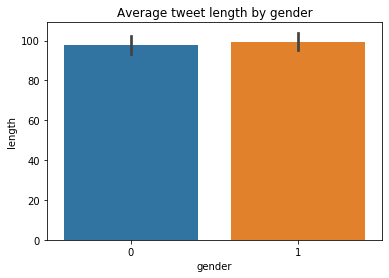

In [27]:
tweets['length'] = tweets['text'].apply(len)
fig1 = sns.barplot('gender', 'length', data=tweets)
plt.title('Average tweet length by gender')

Text(0.5, 1.0, 'Gender counts')

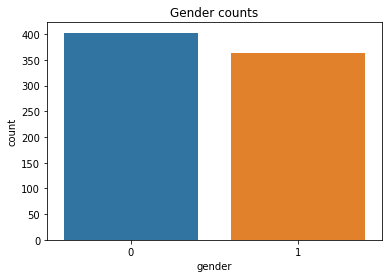

In [28]:
fig2 = sns.countplot(x='gender', data=tweets)
plt.title('Gender counts')

# 3. Clean up data

In [80]:
def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

print(form_sentence(tweets['text'].iloc[10]))
print(tweets['text'].iloc[10])

Graduating is a big achievement no matter what but with all that the Class of 2020 has dealt with to get across th… https t.co/nuR3SUdo8F
Graduating is a big achievement no matter what, but with all that the Class of 2020 has dealt with to get across th… https://t.co/nuR3SUdo8F


In [84]:
def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess
print(no_user_alpha(form_sentence(tweets['text'].iloc[10])))
print(tweets['text'].iloc[10])

['Graduating', 'big', 'achievement', 'matter', 'Class', 'dealt', 'get', 'across', 'https']
Graduating is a big achievement no matter what, but with all that the Class of 2020 has dealt with to get across th… https://t.co/nuR3SUdo8F


In [90]:
def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
print(normalization(tweet_list))
tweets

['I', 'be', 'play', 'with', 'my', 'friends', 'with', 'whom', 'I', 'use', 'to', 'play,', 'when', 'you', 'call', 'me', 'yesterday']


,user,text,gender,length,tweet_list
0,BarackObama,My statement on the death of George Floyd: htt...,0,66,None
1,BarackObama,"If you believe in a more just, more generous, ...",0,140,None
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,140,None
3,BarackObama,And here’s more on the approach Sweden has tak...,0,117,None
4,BarackObama,South Korea has focused on testing to guard ag...,0,87,None
...,...,...,...,...,...
15,NICKIMINAJ,That real ass ain’t keep yo n*gga hooooome. No...,1,110,None
16,NICKIMINAJ,Ummm during the quarantine? I would if they ma...,1,123,None
17,NICKIMINAJ,There are def a few hidden messages in the rem...,1,121,None
18,NICKIMINAJ,Ummmm lol not a chance in hell 🤣 https://t.co/...,1,56,None


In [91]:
tweets['tweet_list'] = tweets['text'].apply(text_processing)
tweets

AttributeError: 'DataFrame' object has no attribute 'split'

In [76]:
# Clean up text
def text_processing(tweet):
    
    # Generating the list of words in the tweet (hastags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet)
    
    # Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    # Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
        return normalization(no_punc_tweet)

In [77]:
tweets['tweet_list'] = tweets['text'].apply(text_processing)

AttributeError: 'DataFrame' object has no attribute 'split'

In [75]:
tweets

,user,text,gender,length,tweet_list
0,BarackObama,My statement on the death of George Floyd: htt...,0,66,None
1,BarackObama,"If you believe in a more just, more generous, ...",0,140,None
2,BarackObama,"On Memorial Day, we honor those who gave all f...",0,140,None
3,BarackObama,And here’s more on the approach Sweden has tak...,0,117,None
4,BarackObama,South Korea has focused on testing to guard ag...,0,87,None
...,...,...,...,...,...
15,NICKIMINAJ,That real ass ain’t keep yo n*gga hooooome. No...,1,110,None
16,NICKIMINAJ,Ummm during the quarantine? I would if they ma...,1,123,None
17,NICKIMINAJ,There are def a few hidden messages in the rem...,1,121,None
18,NICKIMINAJ,Ummmm lol not a chance in hell 🤣 https://t.co/...,1,56,None


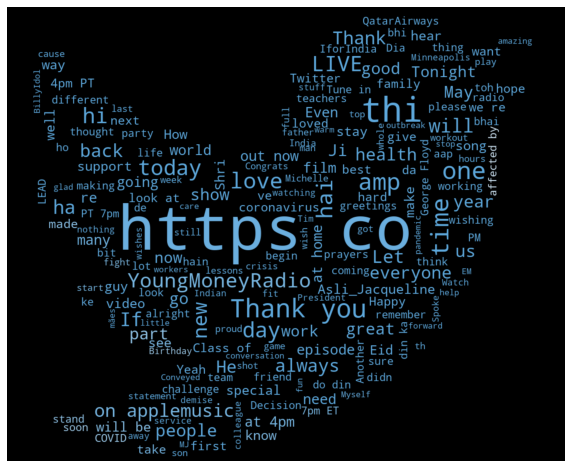

In [32]:
# Plot WordCloud for both genders
# Sort male words
male_words = ' '.join(text for text in tweets['text'][tweets['gender']==0])

# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(male_words)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

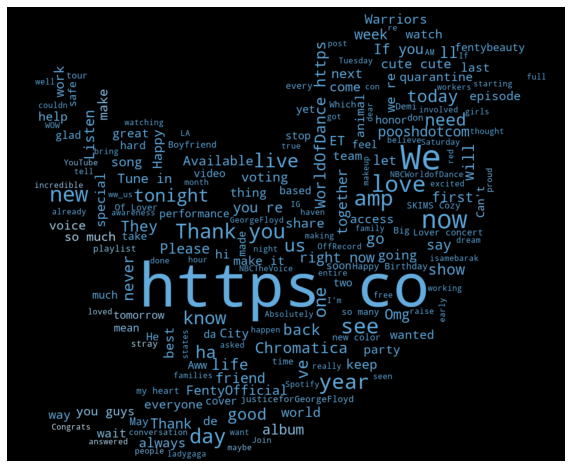

In [33]:
# Sort female words
female_words = ' '.join(text for text in tweets['text'][tweets['gender']==1])

# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(female_words)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()